<a href="https://colab.research.google.com/github/BadalMehtaDS/Upi-Transactions-Failes/blob/main/upi_transactions_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the data

In [ ]:
import pandas as pd
df = pd.read_csv("/content/upi_transactions.csv")

print(df.head())
print(df.info())

  transaction_id user_id transaction_date  transaction_hour  amount   bank  \
0           T001    U001       01-01-2024                 9     250   HDFC   
1           T002    U002       01-01-2024                10    1200    SBI   
2           T003    U003       01-01-2024                11     800  ICICI   
3           T004    U002       01-01-2024                12     300    SBI   
4           T005    U004       02-01-2024                20    1500   HDFC   

    device network   status failure_reason  
0  Android      4G  Success            NaN  
1  Android      4G   Failed        Timeout  
2      iOS    WiFi  Success            NaN  
3  Android      4G   Failed        Timeout  
4  Android      5G  Success            NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    10 non-null     object
 1   user_id         

Basic validation

In [ ]:
# Check missing values
print(df.isna().sum())

# Unique values check
print(df['status'].value_counts())
print(df['bank'].value_counts())


transaction_id      0
user_id             0
transaction_date    0
transaction_hour    0
amount              0
bank                0
device              0
network             0
status              0
failure_reason      4
dtype: int64
status
Failed     6
Success    4
Name: count, dtype: int64
bank
HDFC     4
SBI      4
ICICI    2
Name: count, dtype: int64


Feature Engineering (Required for Analysis)

In [ ]:
#Create failure flag
df['failure_flag'] = df['status'].apply(lambda x: 1 if x == 'Failed' else 0)

#Sort data (important for behavior analysis)
df = df.sort_values(by=['user_id', 'transaction_date', 'transaction_hour'])

#Overall failure rate
total_txn = len(df)
failed_txn = df['failure_flag'].sum()

failure_rate = (failed_txn / total_txn) * 100

print("Total Transactions:", total_txn)
print("Failed Transactions:", failed_txn)
print(f"Failure Rate: {failure_rate:.2f}%")


Total Transactions: 10
Failed Transactions: 6
Failure Rate: 60.00%


Failure rate by bank

In [ ]:
bank_failure = (
    df.groupby('bank')['failure_flag']
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

print(bank_failure)


bank
SBI      100.0
HDFC      50.0
ICICI      0.0
Name: failure_flag, dtype: float64


Time-Based Failure Analysis

In [ ]:
hourly_failures = (
    df.groupby('transaction_hour')['failure_flag']
    .sum()
)

print(hourly_failures)


transaction_hour
9     0
10    1
11    0
12    1
20    0
21    2
22    2
Name: failure_flag, dtype: int64


Simple visualization

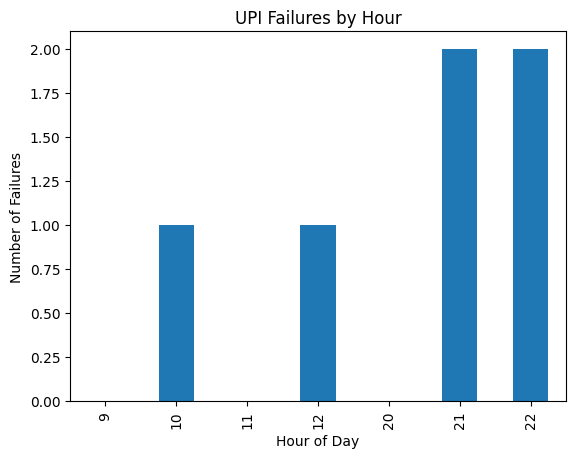

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
hourly_failures.plot(kind='bar')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Failures")
plt.title("UPI Failures by Hour")
plt.show()


User-Level Failure Behavior

In [ ]:
#Failures per user
user_failures = (
    df.groupby('user_id')['failure_flag']
    .sum()
    .reset_index()
)

print(user_failures)

#Identify repeat-failure users
repeat_failures = user_failures[user_failures['failure_flag'] >= 2]
print(repeat_failures)



  user_id  failure_flag
0    U001             0
1    U002             3
2    U003             0
3    U004             0
4    U005             1
5    U006             0
6    U007             2
  user_id  failure_flag
1    U002             3
6    U007             2


Risk Segmentation

In [ ]:
def assign_risk(failures):
    if failures >= 3:
        return "High Risk"
    elif failures == 2:
        return "Medium Risk"
    else:
        return "Low Risk"

user_failures['risk_level'] = user_failures['failure_flag'].apply(assign_risk)

print(user_failures)


  user_id  failure_flag   risk_level
0    U001             0     Low Risk
1    U002             3    High Risk
2    U003             0     Low Risk
3    U004             0     Low Risk
4    U005             1     Low Risk
5    U006             0     Low Risk
6    U007             2  Medium Risk


ADD CHURN LOGIC

In [ ]:
# Last transaction date per user
last_txn = (
    df.groupby('user_id')[['transaction_date', 'transaction_hour']]
    .max()
    .reset_index()
)

last_txn.columns = ['user_id', 'last_txn_date', 'last_txn_hour']

last_failed_txn = (
    df[df['failure_flag'] == 1]
    .groupby('user_id')[['transaction_date', 'transaction_hour']]
    .max()
    .reset_index()
)

last_failed_txn.columns = ['user_id', 'last_failed_date', 'last_failed_hour']

user_activity = pd.merge(
    last_txn,
    last_failed_txn,
    on='user_id',
    how='left'
)

def churn_flag(row):
    if pd.isna(row['last_failed_date']):
        return 0  # never failed → active
    if (
        row['last_failed_date'] == row['last_txn_date'] and
        row['last_failed_hour'] == row['last_txn_hour']
    ):
        return 1  # last action was a failure
    return 0

user_activity['churned'] = user_activity.apply(churn_flag, axis=1)

final_user_table = pd.merge(
    user_failures,
    user_activity[['user_id', 'churned']],
    on='user_id',
    how='left'
)

print(final_user_table)

print(final_user_table.groupby(['risk_level', 'churned']).size())



  user_id  failure_flag   risk_level  churned
0    U001             0     Low Risk        0
1    U002             3    High Risk        1
2    U003             0     Low Risk        0
3    U004             0     Low Risk        0
4    U005             1     Low Risk        1
5    U006             0     Low Risk        0
6    U007             2  Medium Risk        1
risk_level   churned
High Risk    1          1
Low Risk     0          4
             1          1
Medium Risk  1          1
dtype: int64
